In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
import joblib

그래픽카드 인식 확인  
['0.Leonardite(연갈탄)', '1.Lignite(갈탄)', '2.Charcoal(목탄)', '3.Waste(폐경석)']  
라벨값은 한글 제거를 위하여 바꿀것이므로 미리 적어놓았다

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13578556069684147426
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4851040256
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7195330795299441801
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [3]:
path="D:\Image_data"

In [29]:
temp = keras.preprocessing.image.load_img(new_path, target_size=(250, 250))

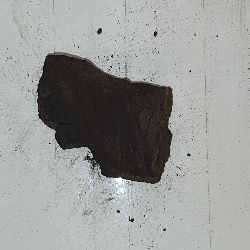

In [30]:
temp

In [4]:
labels = os.listdir(path)

**폴더를 하나씩 돌며 이미지를 읽어보면 원래 픽셀 값(4032, 3024)로 읽어들일시 첫번째 폴더를 읽지 못하고 메모리가 터짐**  
OpenCV(4.5.1) ..\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 36578304 bytes in function 'cv::OutOfMemoryError'

In [26]:
new_path =os.path.join(path, i, j)

In [9]:
temp = cv2.imread(os.path.join(path, i, j))

In [11]:
temp = temp /255.

In [14]:
cv2.resize(temp, (250, 250), interpolation=cv2.INTER_LINEAR)

array([[[0.70681933, 0.73034874, 0.71074089],
        [0.71316078, 0.72884706, 0.70923922],
        [0.71157647, 0.72726275, 0.7076549 ],
        ...,
        [0.65206275, 0.67559216, 0.67167059],
        [0.65218824, 0.67571765, 0.67179608],
        [0.68134902, 0.70095686, 0.69703529]],

       [[0.71280307, 0.73633249, 0.71672464],
        [0.71590312, 0.7315894 , 0.71198155],
        [0.73148267, 0.74716894, 0.7275611 ],
        ...,
        [0.68297945, 0.70650886, 0.70258729],
        [0.64073725, 0.66426667, 0.6603451 ],
        [0.67058824, 0.69019608, 0.68235294]],

       [[0.71985882, 0.74338824, 0.72378039],
        [0.72348204, 0.73916831, 0.71956047],
        [0.72870588, 0.74439216, 0.72478431],
        ...,
        [0.67129412, 0.69482353, 0.69090196],
        [0.68494086, 0.70847027, 0.70454871],
        [0.67912157, 0.69872941, 0.69088627]],

       ...,

       [[0.73214118, 0.73606275, 0.72037647],
        [0.72731012, 0.73123169, 0.71554541],
        [0.73281098, 0

In [6]:
### (250, 250)픽셀로 읽어 들이는데 19분
### 픽셀값 변경을 원할떄만 실행시키며 그렇지 않은 경우 아래의 joblib을 이용하여 가져올 것, 실행시간: 5초 이하
img_list=[]
label_list=[]
for i in os.listdir(path):
    print("Progressing...")
    for j in os.listdir(os.path.join(path, i)):
        img = cv2.imread(os.path.join(path, i, j))
        img = img/255.
        img = cv2.resize(img, (250, 250), interpolation=cv2.INTER_LINEAR)
        img_list.append(img)
        label_list.append(i)

Progressing...


KeyboardInterrupt: 

In [6]:
img_list = joblib.load("./img_array.pkl")

In [7]:
img_list = np.float16(img_list)
img_list = img_list/255.0
label_list = np.array(label_list).astype("int16")

In [8]:
pd.Series(label_list).value_counts()

0    2224
1    2168
2    1552
3    1336
dtype: int64

라벨값이 과하게 편향되지는 않은것 같다 confusion_matrix를 그린 다음 2, 3번 라벨의 문제가 많다면 이미지 비를 조절해줄것

In [20]:
model = keras.Sequential([
    keras.layers.Conv2D(8, kernel_size=5,activation="relu", padding="SAME", input_shape=(120, 120, 3)),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(16, kernel_size=3,activation="relu", padding="SAME"),
    keras.layers.MaxPool2D(2),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(4, activation="softmax")

])

In [21]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 120, 120, 8)       608       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 60, 60, 16)        1168      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 68        
Total params: 1,844
Trainable params: 1,844
Non-trainable params: 0
____________________________________________________

In [15]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(img_list,label_list, epochs=10, validation_split=0.2, batch_size=16)

Epoch 1/10
363/364 [============================>.] - ETA: 0s - loss: 1.0959 - accuracy: 0.4141

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [17]:
from tensorflow.keras import backend as K 

In [18]:
K.clear_session()

In [19]:
import gc
K.clear_session()
gc.collect()

11062

In [20]:
del model